In [1]:
## import numpy as np # linear algebra
from matplotlib import pyplot as plt
#We need these in this file:
import sys
sys.path.append('cropping')
sys.path.append('scripts')
import load_read_name_extractor as lrne
import SVM_classifier_general as svm_general

#Taget fra længere nede i koden:
import torch
from torchvision import transforms
from PIL import Image
import random
import itertools
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np
import DeepFunctions as df
from random import shuffle
from torch.utils.data import Dataset, DataLoader, random_split
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from torchvision import transforms
from IPython.display import display
import os
import json
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch
import torch.nn as nn
import torch.nn.functional as F

c:\Users\marti\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
# Call the function to list GPU names
df.list_gpu_names()
#R
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Number of available GPUs: 2
GPU 0: NVIDIA GeForce RTX 2070 SUPER
GPU 1: NVIDIA GeForce GTX 1050 Ti
cuda:0


In [3]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3,stride=1):
        super(ResidualBlock, self).__init__()

        # Define the convolutional layers
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection (identity mapping)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        # Add the shortcut connection
        out += self.shortcut(residual)
        out = self.relu(out)

        return out

In [4]:
kernel_size = 3
kernel_size1 = 3
padding = 0
# define network
conv1toconv2 = 16
conv2toconv3 = 32
conv3toconv4 = 64
conv4toconv5 = 128
conv5tores1 = 256
res1tores2 = 256
res2tores3 = 256
res3tores4 = 256
res4tores5 = 256
res5tores6 = 256
res6tolin1 = 256
lin = 256
momentum = 0.1

class NeuralNetwork(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(NeuralNetwork, self).__init__()
        
        self.conv1 = nn.Conv2d(3, conv1toconv2, kernel_size, padding=padding)
        self.bn1 = nn.BatchNorm2d(conv1toconv2)
        self.conv2 = nn.Conv2d(conv1toconv2, conv2toconv3, kernel_size, padding=padding)
        self.bn2 = nn.BatchNorm2d(conv2toconv3)
        self.conv3 = nn.Conv2d(conv2toconv3, conv3toconv4, kernel_size, padding=padding)
        self.bn3 = nn.BatchNorm2d(conv3toconv4)
        self.conv4 = nn.Conv2d(conv3toconv4, conv4toconv5, kernel_size, padding=padding)
        self.bn4 = nn.BatchNorm2d(conv4toconv5)
        self.conv5 = nn.Conv2d(conv4toconv5, conv5tores1, kernel_size, padding=padding)
        self.bn5 = nn.BatchNorm2d(conv5tores1)
        
        self.residual1 = ResidualBlock(conv5tores1, res1tores2)
        self.residual2 = ResidualBlock(res1tores2, res2tores3)
        self.residual3 = ResidualBlock(res2tores3, res3tores4)
        self.residual4 = ResidualBlock(res4tores5, res4tores5)
        self.residual5 = ResidualBlock(res4tores5, res5tores6)
        self.residual6 = ResidualBlock(res5tores6, res6tolin1)
        
        self.pool = nn.AvgPool2d(2, 2)
        self.poolmax = nn.MaxPool2d(2,2)
        self.flatten = nn.Flatten()
        self.FC1 = nn.Linear(6 * res6tolin1, lin)
        self.bn7 = nn.BatchNorm1d(lin)
        self.FC2 = nn.Linear(lin,lin)
        self.bn8 = nn.BatchNorm1d(lin)
        self.FC3 = nn.Linear(lin, num_classes)
        self.bn9 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        #print(x.shape)
        x = self.poolmax(x)
        
        #print(x.shape)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        #print(x.shape)
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool(x)
        
                                  
        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.pool(x)
        #print(x.shape)
        
        x = self.conv5(x)
        x = self.bn5(x)
        x = F.relu(x)
        x = self.pool(x)
        #print(x.shape)
        
        x = self.residual1(x)
        x = self.residual2(x)
        x = self.residual3(x)
        x = self.residual4(x)
        x = self.residual5(x)
        x = self.residual6(x)
        
        x = self.pool(x)
        
        x = self.flatten(x)
        x = self.FC1(x)
        x = self.bn7(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        x = self.FC2(x)
        x = self.bn8(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        x = self.FC3(x)
        return x

In [5]:
trainDataloader = torch.load('data/train_loader.pth')
valDataloader = torch.load('data/val_loader.pth')
testDataloader = torch.load('data/test_loader.pth')
lenthdataset = torch.load('data/lengthsdataset.pth')

In [6]:
print(lenthdataset)

[7440, 620, 620]


In [7]:
def distribution(dataloader):
    dist = [0] * 10
    for i, data in enumerate(dataloader, 0):
        # Get the inputs and labels
        inputs, labels = data
        for lodg in labels:
            dist[int(lodg)] += 1
    return dist

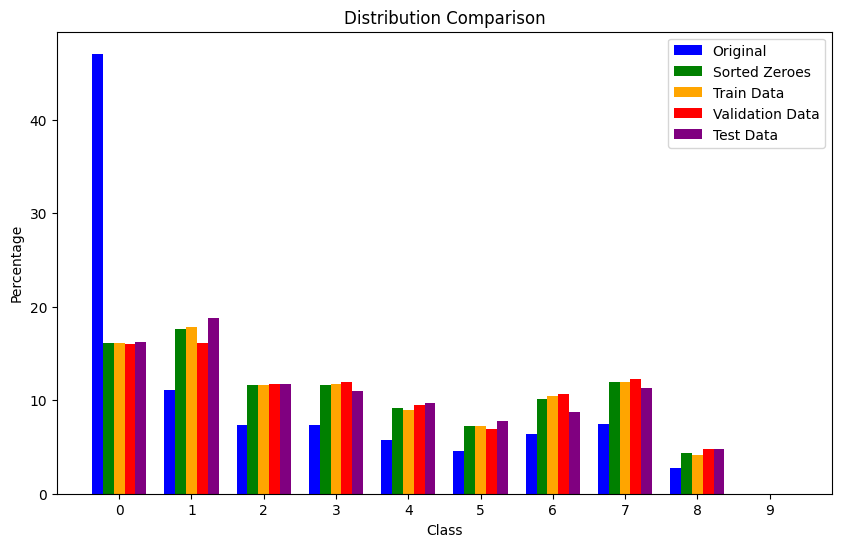

In [8]:
import matplotlib.pyplot as plt
import numpy as np
before = [2314, 548, 362, 360, 285, 226, 314, 369, 136, 1]
after = [8000, 8768, 5792, 5760, 4560, 3616, 5024, 5904, 2176, 0]
train = [1201, 1326, 868, 870, 664, 540, 775, 890, 306, 0]
val = [396, 400, 290, 297, 236, 171, 265, 305, 120, 0]
test = [403, 466, 290, 273, 240, 193, 216, 281, 118, 0]

before_percent = [value / sum(before) * 100 for value in before]
after_percent = [value / sum(after) * 100 for value in after]
train_percent = [value / sum(train) * 100 for value in train]
val_percent = [value / sum(val) * 100 for value in val]
test_percent = [value / sum(test) * 100 for value in test]

# Create indices for each group
indices = np.arange(len(before_percent))

# Set the bar width (optional, adjust as needed)
bar_width = 0.15

# Set the figure size
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the grouped bars without spacing between indices
plt.bar(indices - 2 * bar_width, before_percent, width=bar_width, label='Original', color='blue')
plt.bar(indices - bar_width, after_percent, width=bar_width, label='Sorted Zeroes', color='green')
plt.bar(indices, train_percent, width=bar_width, label='Train Data', color='orange')
plt.bar(indices + bar_width, val_percent, width=bar_width, label='Validation Data', color='red')
plt.bar(indices + 2 * bar_width, test_percent, width=bar_width, label='Test Data', color='purple')

plt.xlabel('Class')
plt.ylabel('Percentage')
plt.title('Distribution Comparison')

# Set x-axis ticks at each index
plt.xticks(indices, indices)

plt.legend()
plt.show()


In [9]:
def create_confusion_matrix(dataloader, net, num_classes=9, device="cpu"):
    # Set the model to evaluation mode
    net.train()
    # Lists to store true labels and predicted labels
    true_labels = []
    predicted_labels = []
    for i, data in enumerate(dataloader, 0):
        # Get the inputs and labels
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # Forward pass
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)  # Assuming a classification task with softmax activation
        # Move tensors to CPU before extending lists
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

    # Convert lists to NumPy arrays
    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)

    # Calculate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    return cm, accuracy_score(true_labels, predicted_labels)

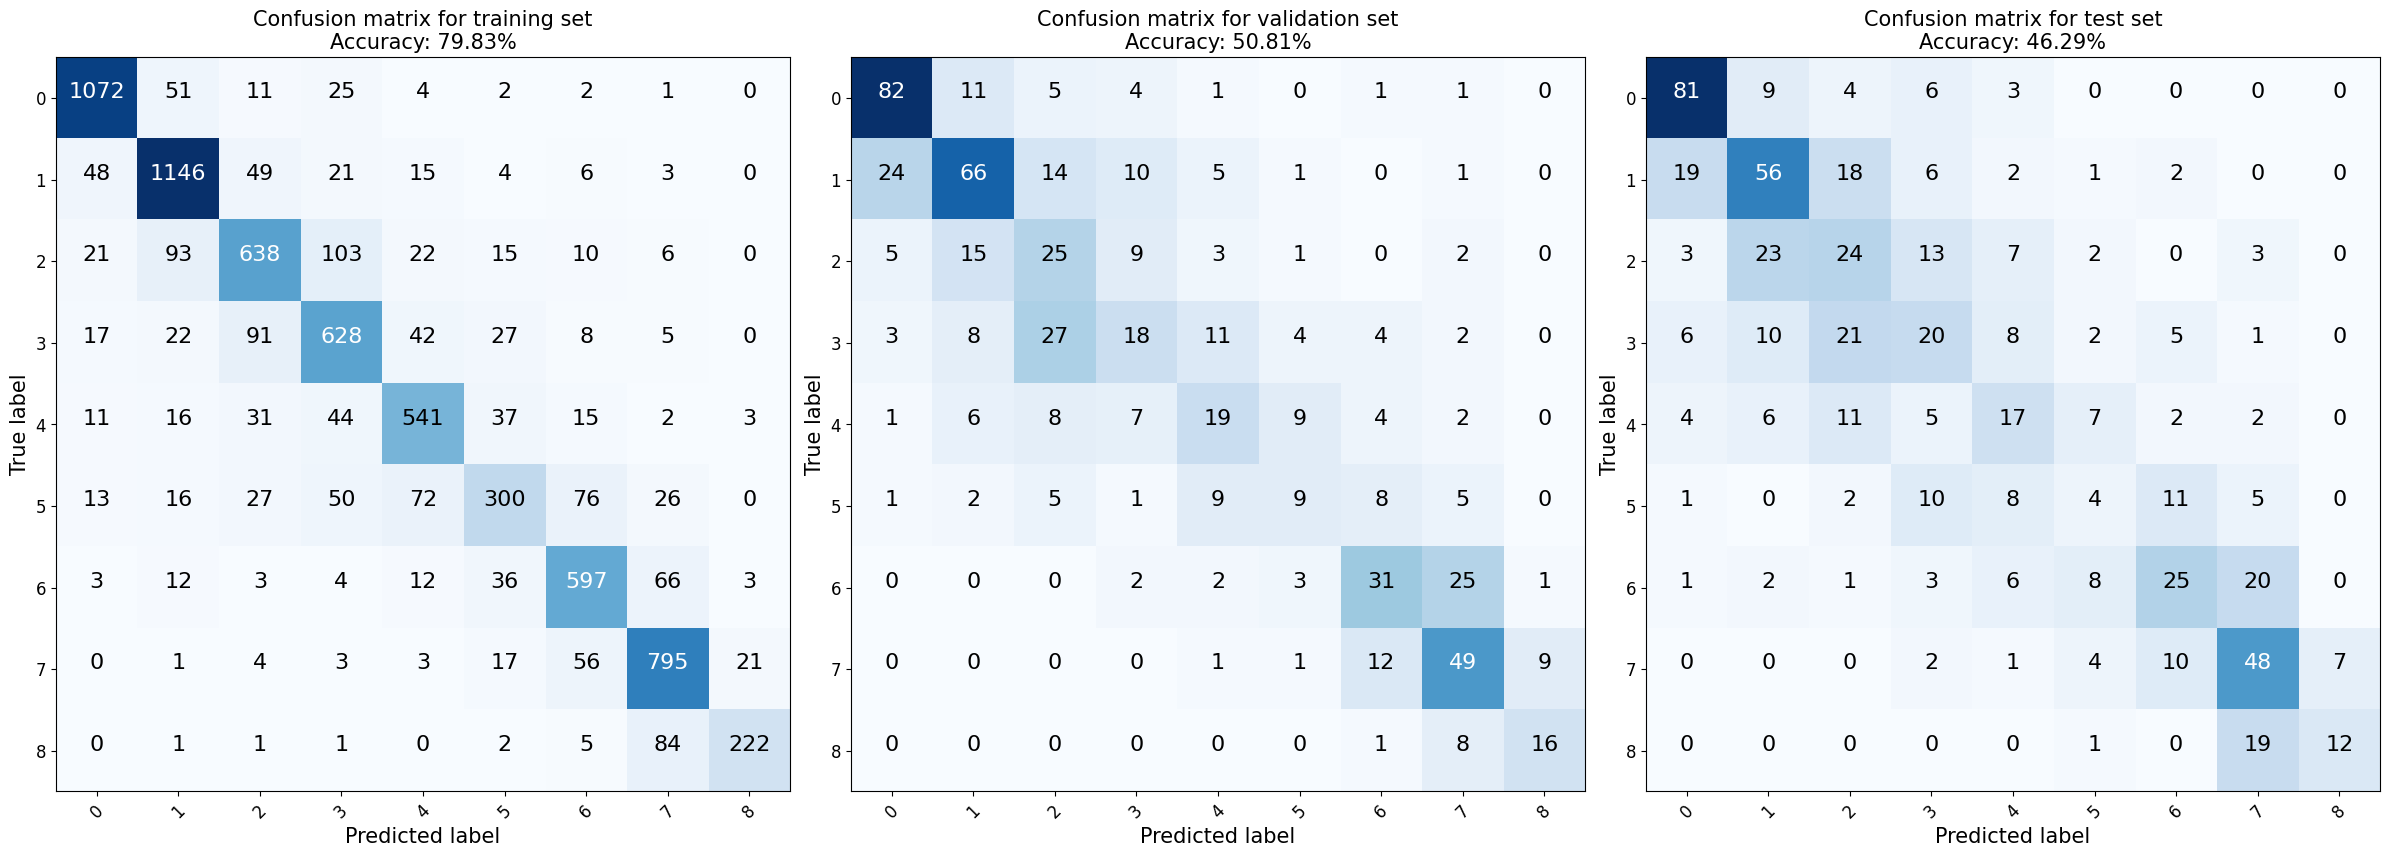

In [10]:
num_classes = 9
bestnet = NeuralNetwork()


path_model = "models/0.5factor/best_model_stateAcc0.508epoch89.0.pt"
bestnet.load_state_dict(torch.load(path_model))
bestnet.to(device)
cm1, acc1 = create_confusion_matrix(trainDataloader, bestnet, device=device)
title1 = 'Confusion matrix for training set'
num_classes = 9
bestnet = NeuralNetwork()


bestnet.load_state_dict(torch.load(path_model))
bestnet.to(device)

cm2, acc2 = df.create_confusion_matrix(valDataloader, bestnet, device=device)
title2 = 'Confusion matrix for validation set'
num_classes = 9
bestnet = NeuralNetwork()


bestnet.load_state_dict(torch.load(path_model))
bestnet.to(device)
cm3, acc3 = df.create_confusion_matrix(testDataloader, bestnet, device=device)
title3 = 'Confusion matrix for test set'
num_classes = 9
bestnet = NeuralNetwork()


bestnet.load_state_dict(torch.load(path_model))
bestnet.to(device)
df.plot_3_confusion_matrices(cm1, cm2, cm3, acc1, acc2, acc3, num_classes, title1, title2, title3)

In [11]:
path_result = "results/1e-05_0_7_0.1_0.2_0.5_50.81%_results.json"
with open(path_result, 'r') as file:
    data = json.load(file)
# Now 'data' contains the content of the JSON file
trainLossList = data['train']['loss']
trainAccList = data['train']['accuracy']
valLossList = data['validation']['loss']
valAccList = data['validation']['accuracy']

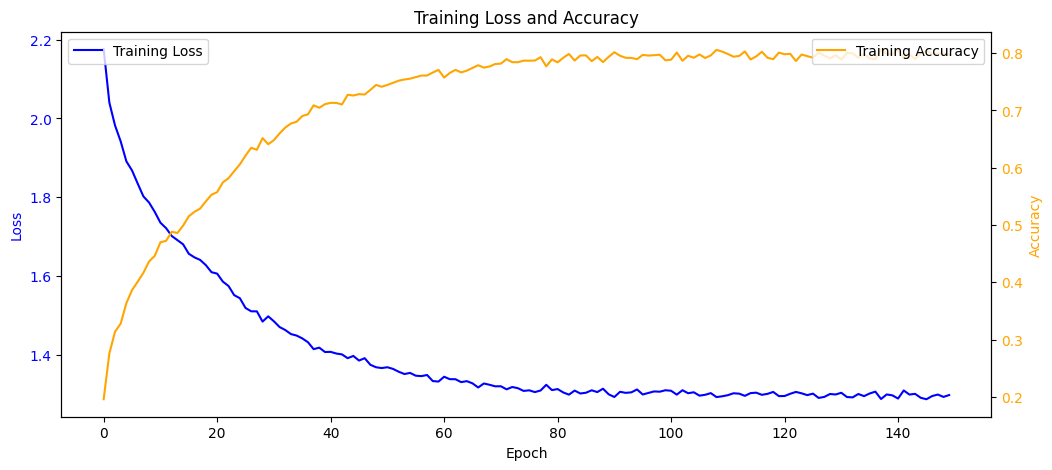

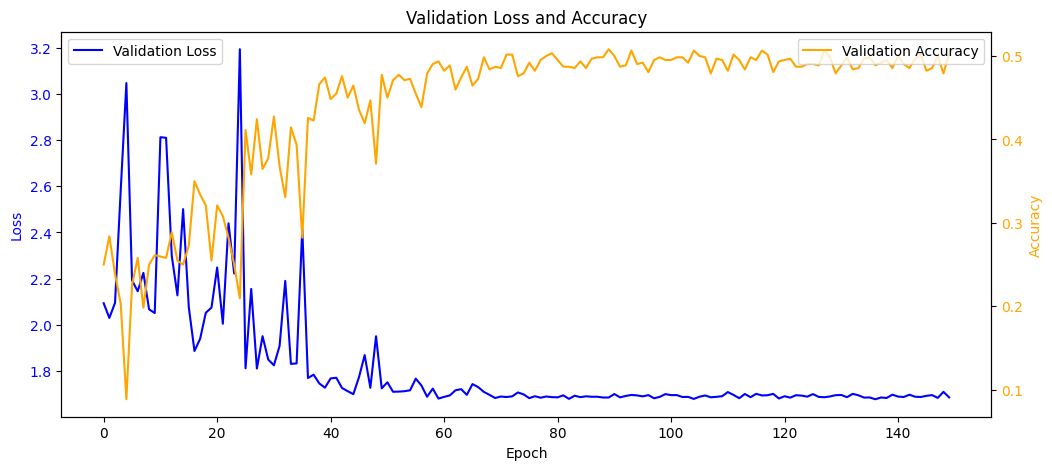

In [12]:
df.plot_loss_and_accuracy(df.transfer_to_cpu(trainLossList), df.transfer_to_cpu(trainAccList), df.transfer_to_cpu(valLossList), df.transfer_to_cpu(valAccList))

In [13]:
lenthdataset[1]

620

In [105]:
import matplotlib.pyplot as plt

def plot_loss_and_accuracy(trainLossList, trainAccList, valLossList, valAccList):
    # Create a single subplot with two y-axes
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot training loss and validation loss on the same axes
    ax1.set_xlabel('Epoch', fontsize=15)
    ax1.set_ylabel('Loss', color='blue', fontsize=15)
    ax1.plot(trainLossList, label='Training Loss', color='blue')
    ax1.plot(valLossList, label='Validation Loss', color='dodgerblue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Create a second y-axis for accuracy
    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy', color='orange', fontsize=15)

    # Plot training accuracy and validation accuracy on the second axes
    ax2.plot(trainAccList, label='Training Accuracy', color='darkorange')
    ax2.plot(valAccList, label='Validation Accuracy', color='coral')
    ax2.tick_params(axis='y', labelcolor='orange')

    # Combine legends into a single legend at a custom position
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    combined_lines = lines + lines2
    combined_labels = labels + labels2
    order = [2, 3, 0, 1]  # Train Accuracy, Val Accuracy, Train Loss, Val Loss
    ax1.legend([combined_lines[i] for i in order], [combined_labels[i] for i in order],
               loc='upper right', bbox_to_anchor=(1.08, 1.35), fontsize=12)  # Adjust the second value (0.8) to lower the legend

    plt.title('Training and Validation Loss/Accuracy', fontsize=18)

    # Increase font size for numbers on the axes
    for ax in [ax1, ax2]:
        ax.tick_params(axis='x', labelsize=12)  # Adjust the font size for x-axis numbers
        ax.tick_params(axis='y', labelsize=12)  # Adjust the font size for y-axis numbers

    plt.tight_layout()
    plt.show()

# Example usage:
# plot_loss_and_accuracy(train_loss, train_acc, val_loss, val_acc)


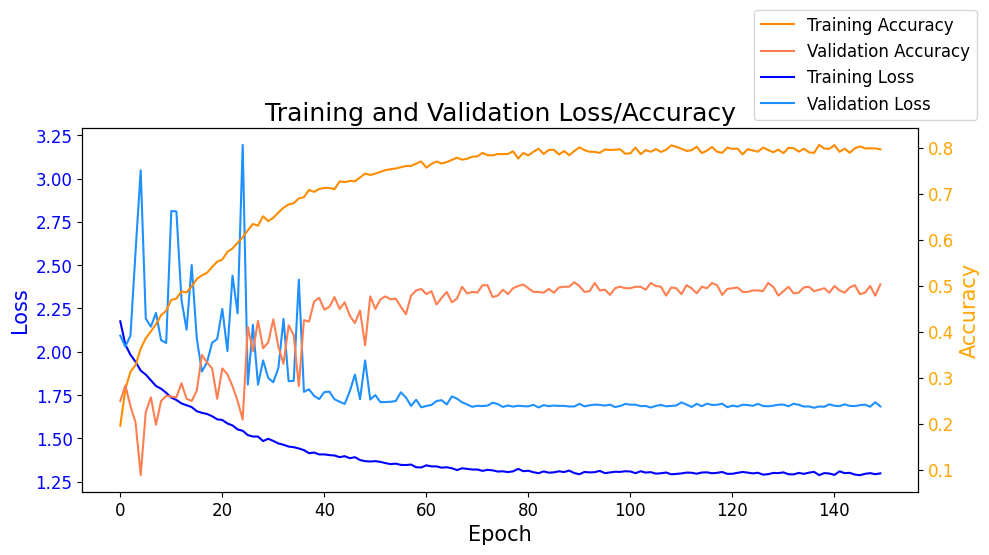

In [106]:
plot_loss_and_accuracy(df.transfer_to_cpu(trainLossList), df.transfer_to_cpu(trainAccList), df.transfer_to_cpu(valLossList), df.transfer_to_cpu(valAccList))